## 1) Imports
- Import core libraries


In [1]:
import duckdb, pandas as pd

## 2) Connect to DuckDB and pull dual-metric view

In [3]:
con = duckdb.connect("data/processed/nba.duckdb")
df_both = con.sql("""
    SELECT *
    FROM v_player_career_dual
    WHERE reg_mp >= 1000
      AND po_mp  >=  500
""").df()
con.close()

 
print("Players available for salary merge:", len(df_both))
df_both.head()

Players available for salary merge: 500


,Player,reg_mp,po_mp,po_ws48,reg_ws48,ws48_diff,bpm_diff
0,Travis Best,11672.0,708.0,0.108475,0.099109,0.009366,8.1
1,P.J. Brown,19900.0,2042.0,0.119882,0.133869,-0.013987,2.9
2,Marcus Camby,27506.0,1736.0,0.069124,0.146412,-0.077287,-34.9
3,Sam Cassell,21881.0,2242.0,0.094202,0.144344,-0.050143,-14.6
4,Derrick Coleman,7745.0,897.0,0.144482,0.116514,0.027968,19.4


## 3) Load Salary CSV


In [7]:
 

# 1. Read and flatten the table
contracts = pd.read_html(
    "https://www.basketball-reference.com/contracts/players.html"
)[0]
contracts.columns = contracts.columns.droplevel(0)

# 2. Pull just Player + 2025‑26
salary_year = "2025-26"
salaries = contracts.loc[:, ["Player", salary_year]].rename(
    columns={salary_year: "Salary"}
)

# 3. Clean & coerce Salary to numeric
salaries["Salary"] = (
    salaries["Salary"]
      .str.replace(r"[\$,]", "", regex=True)    # remove $ and commas
      .pipe(pd.to_numeric, errors="coerce")     # bad values → NaN
)

# 4. Drop any rows where Salary is NaN (i.e. non‑numeric or header repeats)
salaries = salaries.dropna(subset=["Salary"])

# 5. Convert to integer (now safe)
salaries["Salary"] = salaries["Salary"].astype(int)

# 6. Save
salaries.to_csv("data/raw/salaries_2025.csv", index=False)

salaries.head()


,Player,Salary
0,Stephen Curry,59606817
1,Joel Embiid,55224526
2,Nikola Jokić,55224526
3,Kevin Durant,54708609
4,Jayson Tatum,54126450


## 4) Merge Performance with Salary

We join our filtered career‐metrics DataFrame (`df_both`) with the 2025 salary data
to compute:

- **Playoff wins added** ≈ `ws48_diff × (po_mp / 48)`  
- **Dollars per playoff win** = `Salary ÷ playoff_wins_added`


In [8]:
before = len(df_both)
df_val = df_both.merge(salaries, on="Player", how="inner")
after = len(df_val)
print(f"Merged: {after} / {before} players have salary data")

# 4. Compute playoff wins added and dollars per win
df_val["playoff_win_equiv"] = df_val["ws48_diff"] * (df_val["po_mp"] / 48)
# Filter out any zero or negative playoff wins
df_val = df_val[df_val["playoff_win_equiv"] > 0].copy()
df_val["dollars_per_win"] = df_val["Salary"] / df_val["playoff_win_equiv"]

# 5. Quick look
df_val[["Player", "Salary", "ws48_diff", "po_mp", "playoff_win_equiv", "dollars_per_win"]].head()

Merged: 107 / 500 players have salary data


,Player,Salary,ws48_diff,po_mp,playoff_win_equiv,dollars_per_win
2,Kawhi Leonard,50000000,0.005631,4929.0,0.578261,8.646617e+07
8,Terry Rozier,26643031,0.026994,1234.0,0.693959,3.839280e+07
12,Aaron Gordon,22841455,0.008392,1781.0,0.311360,7.336036e+07
16,Gabe Vincent,11500000,0.006517,1178.0,0.159944,7.190006e+07
23,Tyrese Haliburton,45550512,0.019933,522.0,0.216775,2.101282e+08


### 7️⃣ Top 10 Best Bargains

These players delivered the **most playoff wins per dollar** (lowest dollars_per_win).


In [9]:
# Identify the 10 players with the lowest $/win
best_bargains = df_val.nsmallest(10, "dollars_per_win")[[
    "Player",
    "playoff_win_equiv",
    "Salary",
    "dollars_per_win"
]].reset_index(drop=True)

display(best_bargains)


,Player,playoff_win_equiv,Salary,dollars_per_win
0,P.J. Tucker,2.192465,3468960,1.582219e+06
1,JaVale McGee,0.671409,2208856,3.289884e+06
2,Pat Connaughton,1.010963,9423869,9.321671e+06
3,Draymond Green,2.062380,25892857,1.255484e+07
4,Grant Williams,0.975437,13645500,1.398912e+07
5,LeBron James,3.429572,52627153,1.534511e+07
6,Andrew Nembhard,1.129761,18102000,1.602285e+07
7,Caleb Martin,0.410899,9594044,2.334891e+07
8,Anthony Edwards,1.903503,45550512,2.392984e+07
9,Jordan Poole,1.114665,31848215,2.857201e+07


### 8️⃣ Top 10 Over‑Paid Under‑Performers

These players cost the **most dollars per playoff win added** (highest dollars_per_win).


In [10]:
# Identify the 10 players with the highest $/win
worst_value = df_val.nlargest(10, "dollars_per_win")[[
    "Player",
    "playoff_win_equiv",
    "Salary",
    "dollars_per_win"
]].reset_index(drop=True)

display(worst_value)


,Player,playoff_win_equiv,Salary,dollars_per_win
0,Ja Morant,0.098020,39446090,4.024298e+08
1,Cameron Johnson,0.095926,20543478,2.141599e+08
2,Tyrese Haliburton,0.216775,45550512,2.101282e+08
3,Kentavious Caldwell-Pope,0.159094,21621500,1.359036e+08
4,Josh Green,0.108922,13666667,1.254718e+08
5,Devin Booker,0.443569,53142264,1.198061e+08
6,Deandre Ayton,0.343096,35550814,1.036177e+08
7,Kawhi Leonard,0.578261,50000000,8.646617e+07
8,Aaron Gordon,0.311360,22841455,7.336036e+07
9,Anthony Davis,0.742583,54126450,7.288939e+07


### 9️⃣ Bubble Chart: Performance Δ vs. Salary

- **X‑axis**: Career WS/48 Δ  
- **Y‑axis**: 2025‑26 Salary (millions USD)  
- **Bubble size**: Playoff wins added (`playoff_win_equiv`)


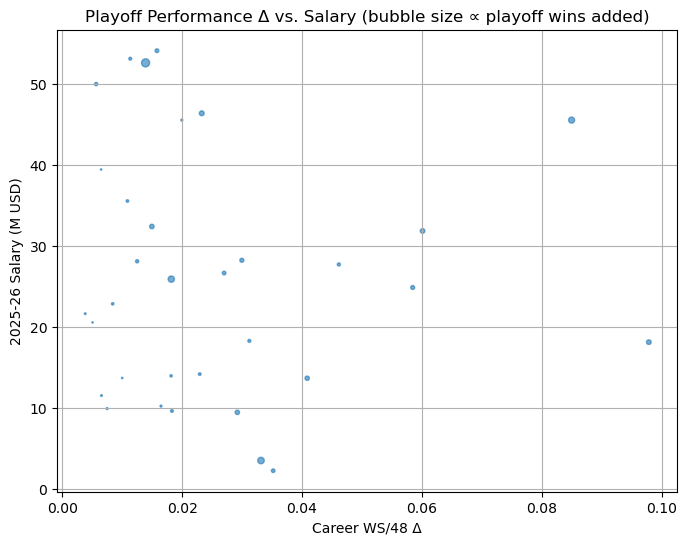

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.scatter(
    df_val["ws48_diff"],
    df_val["Salary"] / 1e6,
    s=df_val["playoff_win_equiv"] * 10,
    alpha=0.6
)
plt.xlabel("Career WS/48 Δ")
plt.ylabel("2025‑26 Salary (M USD)")
plt.title("Playoff Performance Δ vs. Salary (bubble size ∝ playoff wins added)")
plt.grid(True)
plt.show()
